In [1]:
import tensorflow as tf
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
import pickle
import tensorflow.keras as keras 
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers 
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, ReLU  
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.applications import EfficientNetB0

2025-05-17 08:36:12.987830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747470973.176380      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747470973.230800      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
concepts = pd.read_csv("/kaggle/input/medical-final/train_concepts.csv")
val_concepts = pd.read_csv("/kaggle/input/medical-final/valid_concepts.csv")

In [3]:
concepts

,ID,CUIs
0,ImageCLEFmedical_Caption_2025_train_0,C0040405
1,ImageCLEFmedical_Caption_2025_train_1,C1306645;C0817096;C0442800;C0018787;C0242073
2,ImageCLEFmedical_Caption_2025_train_2,C0040405;C0856747
3,ImageCLEFmedical_Caption_2025_train_3,C0041618
4,ImageCLEFmedical_Caption_2025_train_4,C0040405;C0040053
...,...,...
80086,ImageCLEFmedical_Caption_2025_train_80086,C0920367
80087,ImageCLEFmedical_Caption_2025_train_80087,C0920367
80088,ImageCLEFmedical_Caption_2025_train_80088,C0920367;C0003151;C0015385
80089,ImageCLEFmedical_Caption_2025_train_80089,C0920367;C0035298


In [4]:
copy = concepts.copy()

In [5]:
copy['CUIs']= copy['CUIs'].str.split(';')

In [6]:
x = sum(copy.CUIs, [])
from collections import Counter
c = Counter(x)


In [125]:
results =c.most_common(50)
most_frequent = pd.DataFrame(results)

In [126]:
most_frequent.columns = ['CUIs','Images']

In [127]:
most_frequent

,CUIs,Images
0,C0040405,27792
1,C1306645,21992
2,C0024485,12666
3,C0041618,11425
4,C0817096,10233
5,C0002978,4796
6,C0000726,4281
7,C0037303,4110
8,C0030797,3662
9,C0023216,3231


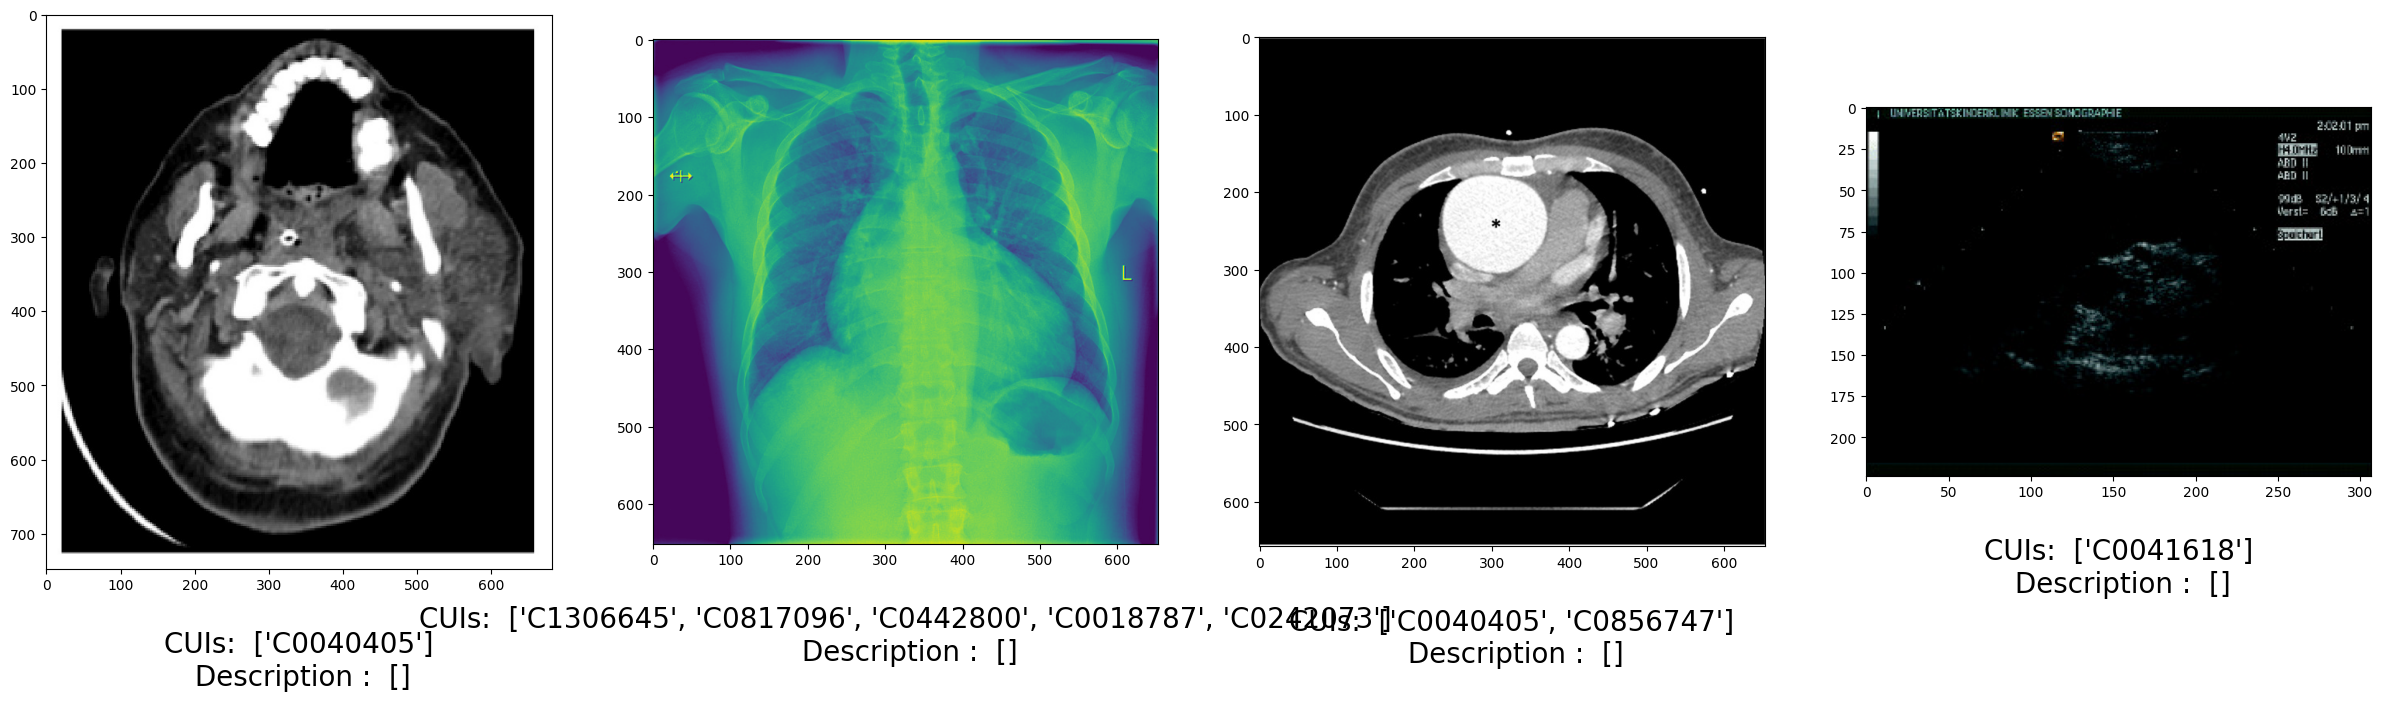

In [12]:
plt.figure(figsize=(30,30))
for i in range(4):
    plt.subplot(1,4,i+1)
    
    img = Image.open('/kaggle/input/medical-final/train/home/damm/clef/data/2025/splits/train/'+copy.ID[i]+'.jpg')
    plt.imshow(img)
    desc = []
    
    plt.xlabel('\n'+'CUIs:  '+ str(copy.CUIs[i])+ '\n Description :  '+ str(desc) ,fontsize = 20)

# DATA PREPROCESSING

In [13]:
concepts['CUIs']= concepts['CUIs'].str.split(';')
concepts['ID'] = concepts['ID'] +'.jpg'
concepts.head()

,ID,CUIs
0,ImageCLEFmedical_Caption_2025_train_0.jpg,[C0040405]
1,ImageCLEFmedical_Caption_2025_train_1.jpg,"[C1306645, C0817096, C0442800, C0018787, C0242..."
2,ImageCLEFmedical_Caption_2025_train_2.jpg,"[C0040405, C0856747]"
3,ImageCLEFmedical_Caption_2025_train_3.jpg,[C0041618]
4,ImageCLEFmedical_Caption_2025_train_4.jpg,"[C0040405, C0040053]"


In [14]:
concepts

,ID,CUIs
0,ImageCLEFmedical_Caption_2025_train_0.jpg,[C0040405]
1,ImageCLEFmedical_Caption_2025_train_1.jpg,"[C1306645, C0817096, C0442800, C0018787, C0242..."
2,ImageCLEFmedical_Caption_2025_train_2.jpg,"[C0040405, C0856747]"
3,ImageCLEFmedical_Caption_2025_train_3.jpg,[C0041618]
4,ImageCLEFmedical_Caption_2025_train_4.jpg,"[C0040405, C0040053]"
...,...,...
80086,ImageCLEFmedical_Caption_2025_train_80086.jpg,[C0920367]
80087,ImageCLEFmedical_Caption_2025_train_80087.jpg,[C0920367]
80088,ImageCLEFmedical_Caption_2025_train_80088.jpg,"[C0920367, C0003151, C0015385]"
80089,ImageCLEFmedical_Caption_2025_train_80089.jpg,"[C0920367, C0035298]"


In [15]:
val_concepts['CUIs']= val_concepts['CUIs'].str.split(';')
val_concepts['ID']= val_concepts['ID']+'.jpg'
val_concepts.head()

,ID,CUIs
0,ImageCLEFmedical_Caption_2025_valid_0.jpg,"[C0041618, C0027651]"
1,ImageCLEFmedical_Caption_2025_valid_1.jpg,"[C1306645, C0000726, C0017070]"
2,ImageCLEFmedical_Caption_2025_valid_2.jpg,"[C1306645, C0037949, C0017070]"
3,ImageCLEFmedical_Caption_2025_valid_3.jpg,"[C1306645, C0000726, C0183512]"
4,ImageCLEFmedical_Caption_2025_valid_4.jpg,"[C1306645, C0000726, C0016169]"


In [53]:
train_dir = '/kaggle/input/medical-final/train/home/damm/clef/data/2025/splits/train'
validation_dir = '/kaggle/input/medical-final/valid/home/damm/clef/data/2025/splits/valid'
test_dir = '/kaggle/input/medical-final/test'

In [20]:
num_tr = len(os.listdir(train_dir))
num_val = len(os.listdir(validation_dir))
num_test = len(os.listdir(test_dir))
total_train = num_tr
total_val = num_val
total_test = num_test

In [21]:
print('total training images:', num_tr)
print('total validation images:', num_val)
print('total test images:', num_test)

total training images: 80091
total validation images: 17277
total test images: 19267


In [22]:
batch_size = 128
epochs = 2
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [23]:
train_image_generator = ImageDataGenerator(rescale=1./255,horizontal_flip = True)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)

In [24]:
concepts['index'] = concepts.index

In [25]:
val_concepts['index'] = val_concepts.index

In [26]:
full = pd.concat([concepts, val_concepts], sort=False)

In [27]:
full

,ID,CUIs,index
0,ImageCLEFmedical_Caption_2025_train_0.jpg,[C0040405],0
1,ImageCLEFmedical_Caption_2025_train_1.jpg,"[C1306645, C0817096, C0442800, C0018787, C0242...",1
2,ImageCLEFmedical_Caption_2025_train_2.jpg,"[C0040405, C0856747]",2
3,ImageCLEFmedical_Caption_2025_train_3.jpg,[C0041618],3
4,ImageCLEFmedical_Caption_2025_train_4.jpg,"[C0040405, C0040053]",4
...,...,...,...
17272,ImageCLEFmedical_Caption_2025_valid_17272.jpg,"[C0920367, C0229089, C0035298, C0229090]",17272
17273,ImageCLEFmedical_Caption_2025_valid_17273.jpg,[C0920367],17273
17274,ImageCLEFmedical_Caption_2025_valid_17274.jpg,"[C0920367, C0154844]",17274
17275,ImageCLEFmedical_Caption_2025_valid_17275.jpg,"[C0920367, C0038257]",17275


In [208]:
train_data_gen = train_image_generator.flow_from_dataframe(dataframe=full.iloc[0:80091],
                                                           directory = train_dir,
                                                           x_col="ID",
                                                           y_col="index",
                                                           batch_size=batch_size,
                                                           shuffle=False,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode = 'other'
                                                          )

Found 80091 validated image filenames.


In [209]:
train_data_gen

In [132]:
x, _ = next(train_data_gen)
print(x.shape)

(128, 224, 224, 3)


In [201]:
from collections import Counter

# Flatten the list of CUI lists
all_cuis = [cui for cuis in full['CUIs'].values for cui in cuis]
top_100_cuis = [cui for cui, _ in Counter(all_cuis).most_common(10)]


In [202]:
# Keep only top-100 CUIs per row
full['CUIs'] = full['CUIs'].apply(lambda cuis: [cui for cui in cuis if cui in top_100_cuis])


In [203]:
full

,ID,CUIs,index
0,ImageCLEFmedical_Caption_2025_train_0.jpg,[C0040405],0
1,ImageCLEFmedical_Caption_2025_train_1.jpg,"[C1306645, C0817096]",1
2,ImageCLEFmedical_Caption_2025_train_2.jpg,[C0040405],2
3,ImageCLEFmedical_Caption_2025_train_3.jpg,[C0041618],3
4,ImageCLEFmedical_Caption_2025_train_4.jpg,[C0040405],4
...,...,...,...
17272,ImageCLEFmedical_Caption_2025_valid_17272.jpg,[],17272
17273,ImageCLEFmedical_Caption_2025_valid_17273.jpg,[],17273
17274,ImageCLEFmedical_Caption_2025_valid_17274.jpg,[],17274
17275,ImageCLEFmedical_Caption_2025_valid_17275.jpg,[],17275


In [204]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(full['CUIs'].values)

MultiLabelBinarizer()

In [205]:
N_LABELS = len(mlb.classes_)

In [206]:
N_LABELS

10

In [207]:
list(mlb.classes_)

['C0000726',
 'C0002978',
 'C0023216',
 'C0024485',
 'C0030797',
 'C0037303',
 'C0040405',
 'C0041618',
 'C0817096',
 'C1306645']

In [180]:
def multilabel_flow_from_dataframe(data_generator, mlb,df):
    for x, y in data_generator:
        indices = y.astype(int).tolist()
        y_multi = mlb.transform(
            df.iloc[indices]['CUIs'].values.tolist()
        )
        yield x, y_multi

In [210]:
multilabel_generator_train = multilabel_flow_from_dataframe(
    train_data_gen, mlb,concepts
)

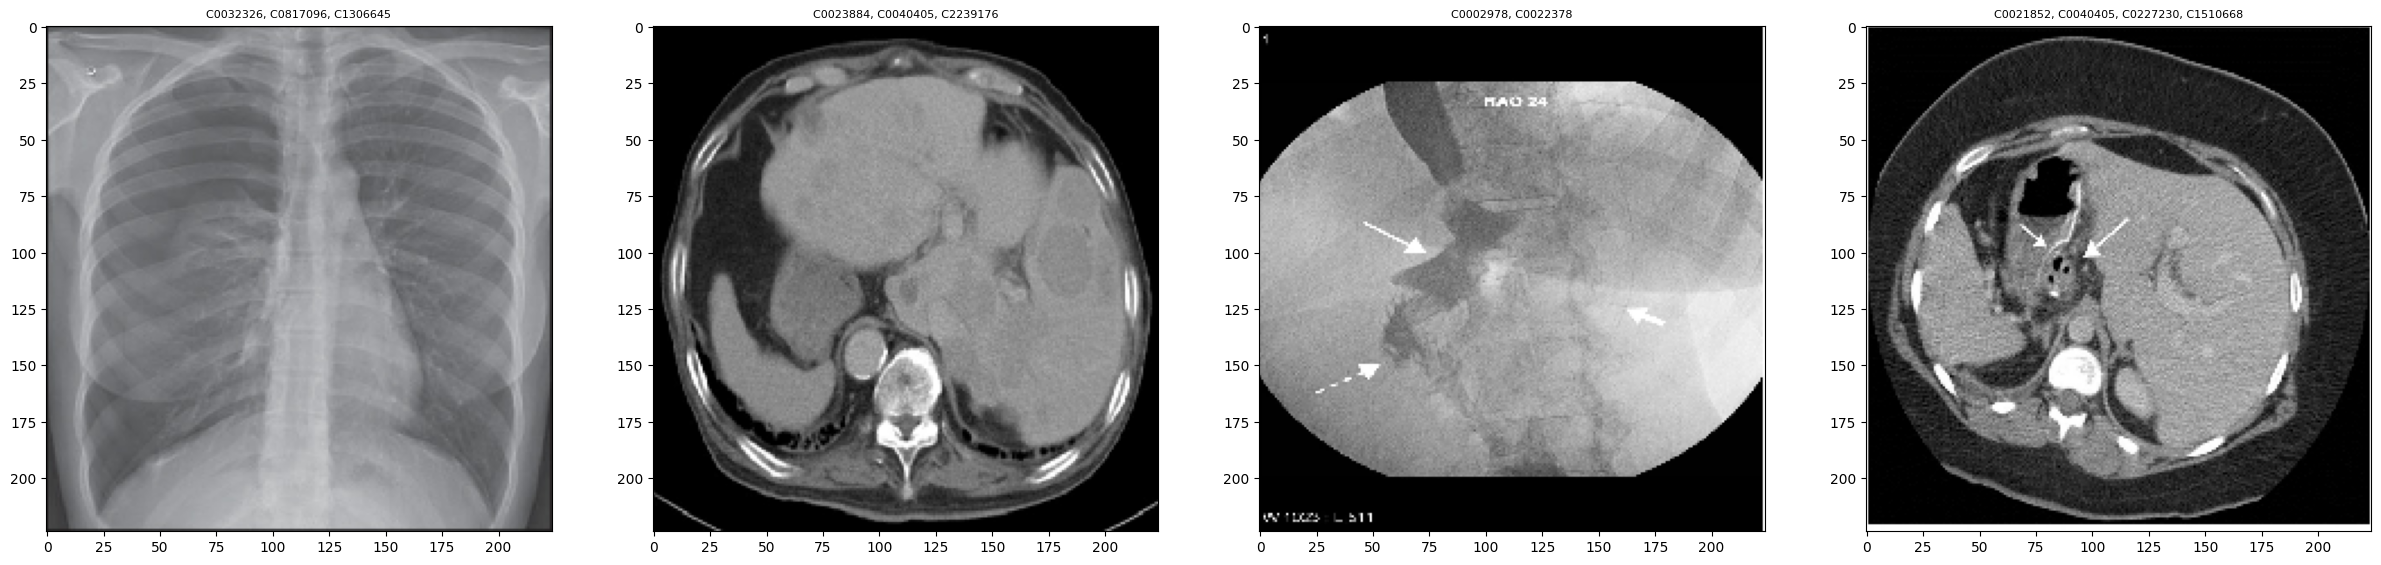

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of images and multi-labels
images, labels = next(multilabel_generator_train)  # replace with your actual generator

# Optionally, get label names if using MultiLabelBinarizer
# Assume `mlb` is your fitted MultiLabelBinarizer
label_names = mlb.classes_  # ['label1', 'label2', ...]

# Number of images in the batch
n = min(len(images), 4)  # Display up to 8
plt.figure(figsize=(30,30))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(images[i])
   
    
    # Decode label vector to class names
    label_vec = labels[i]
    label_text = ", ".join(np.array(label_names)[label_vec.astype(bool)])
    plt.title(label_text, fontsize=8)


plt.show()


In [211]:
val_data_gen = validation_image_generator.flow_from_dataframe(dataframe = full.iloc[80091:97368],
                                                             directory=validation_dir,
                                                             x_col = "ID",
                                                             y_col = "index",
                                                             shuffle = False,
                                                             batch_size=batch_size,
                                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             class_mode='other')

Found 17277 validated image filenames.


In [212]:
val_concepts['CUIs'] = val_concepts['CUIs'].apply(lambda cuis: [cui for cui in cuis if cui in top_100_cuis])
concepts['CUIs'] = concepts['CUIs'].apply(lambda cuis: [cui for cui in cuis if cui in top_100_cuis])

In [213]:
concepts 

,ID,CUIs,index
0,ImageCLEFmedical_Caption_2025_train_0.jpg,[C0040405],0
1,ImageCLEFmedical_Caption_2025_train_1.jpg,"[C1306645, C0817096]",1
2,ImageCLEFmedical_Caption_2025_train_2.jpg,[C0040405],2
3,ImageCLEFmedical_Caption_2025_train_3.jpg,[C0041618],3
4,ImageCLEFmedical_Caption_2025_train_4.jpg,[C0040405],4
...,...,...,...
80086,ImageCLEFmedical_Caption_2025_train_80086.jpg,[],80086
80087,ImageCLEFmedical_Caption_2025_train_80087.jpg,[],80087
80088,ImageCLEFmedical_Caption_2025_train_80088.jpg,[],80088
80089,ImageCLEFmedical_Caption_2025_train_80089.jpg,[],80089


In [214]:
multilabel_generator_val = multilabel_flow_from_dataframe(
    val_data_gen,mlb,val_concepts
)

In [54]:
test_image_generator1 = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=None,  
    shuffle=False  
)


Found 19267 images belonging to 1 classes.


In [55]:
print(batch_size)
print(IMG_HEIGHT, IMG_WIDTH)
print(test_dir)

128
224 224
/kaggle/input/medical-final/test


In [215]:
from tensorflow.keras.applications import DenseNet121,InceptionResNetV2,ResNet50,InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, ReLU ,BatchNormalization 

inputs = Input(shape=(224, 224, 3))


base_model = ResNet50(include_top=False, input_tensor=inputs, weights=None)
base_model.load_weights("/kaggle/input/radimage/keras/default/1/RadImageNet-ResNet50_notop.h5")
base_model.trainable = False  # freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.3),

    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),

    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    

    Dense(10, activation='sigmoid')  # Multi-label output
])

In [216]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [217]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_202              │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_203              │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_204              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_205              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,821,706 (94.69 MB)

 Trainable params: 1,228,106 (4.68 MB)

 Non-trainable params: 23,593,600 (90.00 MB)

In [ ]:
early_stopping = EarlyStopping(
    min_delta = 0.0001,
    patience = 3,
    restore_best_weights = True,
)

In [ ]:
history = model.fit(
    multilabel_generator_train,
    steps_per_epoch=total_train // batch_size,
    validation_data = multilabel_generator_val,
    validation_steps=total_val // batch_size,
    epochs=50,
    batch_size = 128,
    callbacks = [early_stopping]
)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 606s 941ms/step - accuracy: 0.4965 - loss: 0.2402 - val_accuracy: 0.6132 - val_loss: 0.1474
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 587s 932ms/step - accuracy: 0.5934 - loss: 0.1662 - val_accuracy: 0.6115 - val_loss: 0.1494
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 586s 938ms/step - accuracy: 0.5998 - loss: 0.1575 - val_accuracy: 0.6185 - val_loss: 0.1380
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 587s 940ms/step - accuracy: 0.6031 - loss: 0.1524 - val_accuracy: 0.6318 - val_loss: 0.1388
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 569s 912ms/step - accuracy: 0.6078 - loss: 0.1487 - val_accuracy: 0.6204 - val_loss: 0.1451
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 573s 918ms/step - accuracy: 0.6140 - loss: 0.1462 - val_accuracy: 0.6141 - val_loss: 0.1354
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 573s 917ms/step - accuracy: 0.6200 - loss: 0.1424 - val_accuracy: 0.6181 - val_loss: 0.1374
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 597s 956ms/step - accuracy: 0.6224 -

In [191]:
his = pd.DataFrame(history.history)

In [192]:
his

,accuracy,loss,val_accuracy,val_loss
0,0.464013,0.145742,0.505131,0.116857
1,0.513838,0.121392,0.532684,0.106729
2,0.522867,0.116052,0.518806,0.115022
3,0.529495,0.112033,0.545163,0.103546
4,0.534147,0.109629,0.541489,0.103214
5,0.539700,0.107706,0.524404,0.109121
6,0.543564,0.105807,0.540615,0.100023
7,0.545715,0.104887,0.535833,0.112796
8,0.545452,0.104154,0.538224,0.101405
9,0.547841,0.103858,0.554143,0.099275


In [ ]:
model.save("MEDICAL-FINAL_10_xepochs.h5") 

In [194]:
y_pred = model.predict(test_image_generator1)

151/151 ━━━━━━━━━━━━━━━━━━━━ 121s 773ms/step


In [195]:
y_pred

array([[1.51113389e-04, 2.37291897e-06, 1.25348508e-01, ...,
        4.31876651e-05, 2.62144531e-05, 1.53263973e-04],
       [6.09909948e-05, 1.88027911e-07, 1.99279562e-01, ...,
        2.90949242e-06, 1.73588023e-06, 1.61199368e-05],
       [3.08094807e-02, 8.87272134e-03, 8.52042530e-03, ...,
        6.44483743e-03, 4.23564808e-03, 3.89040202e-01],
       ...,
       [1.10261358e-01, 3.32988748e-05, 6.73073810e-04, ...,
        1.84337795e-02, 6.33998861e-05, 6.65300817e-04],
       [1.09776005e-01, 5.52287474e-06, 1.73806111e-04, ...,
        6.94620935e-03, 2.51288766e-05, 4.67769481e-04],
       [2.79918290e-03, 4.32244269e-06, 5.90691867e-04, ...,
        2.69712061e-01, 5.92466131e-05, 8.57187551e-05]], dtype=float32)

In [58]:
def to_output_file_test(val_predictions,threshold):
    labels = []
    for i in range(val_predictions.shape[0]):
        temp = np.where(val_predictions[i] > threshold)[0]
        label = []
        for value in temp :
            label.append(mlb.classes_[value])
        labels.append(label)  
    files = pd.DataFrame([])
    files = files._append(os.listdir("/home/ex5/Desktop/ImageCLEF/dataset/test_images/test"))
    files.columns = ['image']
    files = files.apply(lambda S:S.str.strip('.jpg'))
    files['CUIs'] = labels
    files['CUIs'] = files['CUIs'].apply(lambda x : split_to_semicolons(x))
    candidate = pd.DataFrame([])
    candidate['pred'] = files.image.map(str) + '\t' + files.CUIs
    return candidate

In [58]:
def split_to_semicolons(values):
    items = ''
    for item in values:
        items = item +';' +items
    items = items.rstrip(';')    
    return items  

In [68]:
def to_output_file(val_predictions,threshold):
    labels = []
    for i in range(val_predictions.shape[0]):
        temp = np.where(val_predictions[i] > threshold)[0]
        label = []
        for value in temp :
            label.append(mlb.classes_[value])
        labels.append(label)  
    files = pd.DataFrame([])
    files = files._append(os.listdir(validation_dir))
    files.columns = ['image']
    files = files.apply(lambda S:S.str.strip('.jpg'))
    files['CUIs'] = labels
    files['CUIs'] = files['CUIs'].apply(lambda x : split_to_semicolons(x))
    candidate = pd.DataFrame([])
    candidate['IMAGE'] = files.image.map(str)
    candidate['CUIS'] = files.CUIs
    return candidate

In [63]:
import os
import numpy as np
import pandas as pd

def to_output_file_test(val_predictions, threshold):
    labels = []
    for i in range(val_predictions.shape[0]):
        temp = np.where(val_predictions[i] > threshold)[0]
        label = [mlb.classes_[value] for value in temp]
        labels.append(label)

    # List image filenames and strip .jpg
    image_filenames = os.listdir(test_dir+'/test')
    image_ids = [fname.replace(".jpg", "") for fname in image_filenames]

    files = pd.DataFrame({'image': image_ids})
    files['CUIs'] = labels
    files['CUIs'] = files['CUIs'].apply(lambda x: ';'.join(x))  # Assuming split_to_semicolons does this

    candidate = pd.DataFrame()
    candidate['IMAGE'] = files['image'].astype(str) 
    candidate['CUIS'] = files['CUIs']
    return candidate


In [196]:
candidate = to_output_file_test(y_pred,0.13)

In [197]:
candidate

,IMAGE,CUIS
0,ImageCLEFmedical_Caption_2025_test_4925,C0024485
1,ImageCLEFmedical_Caption_2025_test_12260,C0006104;C0024485
2,ImageCLEFmedical_Caption_2025_test_16293,C0024485;C0037303;C1306645
3,ImageCLEFmedical_Caption_2025_test_7804,C0041618
4,ImageCLEFmedical_Caption_2025_test_6958,C0002978;C1306645
...,...,...
19262,ImageCLEFmedical_Caption_2025_test_6541,C0817096;C1306645
19263,ImageCLEFmedical_Caption_2025_test_479,C0040405
19264,ImageCLEFmedical_Caption_2025_test_2289,C0040405
19265,ImageCLEFmedical_Caption_2025_test_170,C0040405


In [153]:
candidate['CUIS']= candidate['CUIS'].str.split(';')
candidate['IMAGE']= candidate['IMAGE']+'.jpg'
candidate.head()

,IMAGE,CUIS
0,ImageCLEFmedical_Caption_2025_test_4925.jpg,[C0024485]
1,ImageCLEFmedical_Caption_2025_test_12260.jpg,[C0024485]
2,ImageCLEFmedical_Caption_2025_test_16293.jpg,"[C0024485, C0037303, C0040405, C1306645]"
3,ImageCLEFmedical_Caption_2025_test_7804.jpg,"[C0041618, C0225897]"
4,ImageCLEFmedical_Caption_2025_test_6958.jpg,"[C0000726, C0037949, C0817096, C1306645]"


In [154]:
candidate.shape

(19267, 2)

In [155]:
candidate = candidate.sort_values(by='IMAGE')  # ascending by default

In [156]:
candidate

,IMAGE,CUIS
18043,ImageCLEFmedical_Caption_2025_test_0.jpg,[C0024485]
6553,ImageCLEFmedical_Caption_2025_test_1.jpg,[C0041618]
17014,ImageCLEFmedical_Caption_2025_test_10.jpg,"[C0023216, C1140618, C1306645]"
19133,ImageCLEFmedical_Caption_2025_test_100.jpg,"[C0000726, C0040405]"
9333,ImageCLEFmedical_Caption_2025_test_1000.jpg,"[C0040405, C0817096]"
...,...,...
4783,ImageCLEFmedical_Caption_2025_test_9995.jpg,[C0024485]
6367,ImageCLEFmedical_Caption_2025_test_9996.jpg,"[C0028259, C0041618]"
2108,ImageCLEFmedical_Caption_2025_test_9997.jpg,[C0040405]
1666,ImageCLEFmedical_Caption_2025_test_9998.jpg,"[C0000726, C0030797, C1306645]"


In [157]:
candidate['CUIs'] = candidate['CUIS'].apply(lambda x: ';'.join(x))

In [166]:
#candidate = candidate.drop('CUIS', axis=1)
candidate['ID'] = candidate['ID'].str.replace('.jpg', '', regex=False)


In [199]:
candidate

,ID,CUIs
0,ImageCLEFmedical_Caption_2025_test_4925,C0024485
1,ImageCLEFmedical_Caption_2025_test_12260,C0006104;C0024485
2,ImageCLEFmedical_Caption_2025_test_16293,C0024485;C0037303;C1306645
3,ImageCLEFmedical_Caption_2025_test_7804,C0041618
4,ImageCLEFmedical_Caption_2025_test_6958,C0002978;C1306645
...,...,...
19262,ImageCLEFmedical_Caption_2025_test_6541,C0817096;C1306645
19263,ImageCLEFmedical_Caption_2025_test_479,C0040405
19264,ImageCLEFmedical_Caption_2025_test_2289,C0040405
19265,ImageCLEFmedical_Caption_2025_test_170,C0040405


In [168]:
candidate.to_csv("submission5.csv",index=False)

In [198]:
candidate.rename(columns={'IMAGE': 'ID', 'CUIS': 'CUIs'}, inplace=True)


In [200]:
candidate.to_csv("submission7.csv",index=False)

In [116]:
from ast import literal_eval

mlb = MultiLabelBinarizer()
Y_true = mlb.fit_transform(val_concepts['CUIs'])
Y_pred = mlb.transform(candidate['CUIS'])

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


In [118]:
Y_pred.shape

(17277, 2283)

In [120]:
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, precision_score, recall_score

# Subset accuracy (exact match)
subset_acc = accuracy_score(Y_true, Y_pred)

# Hamming loss
hloss = hamming_loss(Y_true, Y_pred)

# Micro F1, Precision, Recall
f1 = f1_score(Y_true, Y_pred, average='micro')
precision = precision_score(Y_true, Y_pred, average='micro')
recall = recall_score(Y_true, Y_pred, average='micro')

print(f"Subset Accuracy: {subset_acc:.4f}")
print(f"Hamming Loss: {hloss:.4f}")
print(f"F1 Score (Micro): {f1:.4f}")
print(f"Precision (Micro): {precision:.4f}")
print(f"Recall (Micro): {recall:.4f}")


Subset Accuracy: 0.0114
Hamming Loss: 0.0020
F1 Score (Micro): 0.1535
Precision (Micro): 0.1835
Recall (Micro): 0.1320


In [76]:
full['CUIs'].values

array([list(['C0040405']),
       list(['C1306645', 'C0817096', 'C0442800', 'C0018787', 'C0242073']),
       list(['C0040405', 'C0856747']), ...,
       list(['C0920367', 'C0154844']), list(['C0920367', 'C0038257']),
       list(['C0920367'])], dtype=object)